<a href="https://colab.research.google.com/github/darisoy/EE596_Project/blob/main/testing_CNNAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐍 Python setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np
import glob
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📀 Get the data

In [ ]:
!git clone https://github.com/darisoy/EE596_Project.git

Cloning into 'EE596_Project'...
remote: Enumerating objects: 2572, done.
remote: Counting objects: 100% (2572/2572), done.
remote: Compressing objects: 100% (2569/2569), done.
remote: Total 2572 (delta 12), reused 2540 (delta 1), pack-reused 0
Receiving objects: 100% (2572/2572), 37.02 MiB | 39.74 MiB/s, done.
Resolving deltas: 100% (12/12), done.


# 😷 Get random mask

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, min_size=1000).to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
def mask_out(img, output, thres=0.7):
    for idx, box in enumerate(output[0]['boxes'].tolist()):
        score = output[0]['scores'][idx].tolist()
        if score > thres: 
            mask = output[0]['masks'][idx][0].detach().cpu().numpy()
            mask[mask > 0.2] = 1
            mask = cv2.resize(mask, dsize=(img.shape[1], img.shape[0]))
            visMask = (255-(mask * 255)).astype("uint8")
            img = cv2.bitwise_and(img, img, mask=visMask)
    return img

In [ ]:
trf = T.Compose([T.ToTensor()])
def random_mask(i):
    maskname = '/content/EE596_Project/data/furnished/'+str(random.randint(0, 1226))+'.jpg'
    imagename = '/content/EE596_Project/data/empty/'+str(i)+'.jpg'
    model.eval()
    try:
        image = Image.open(glob.glob(maskname)[0])
    except:
        print(maskname)
    input = trf(image)
    input = torch.unsqueeze(input, 0).to(device)
    output = model(input)
    return cv2.imread(imagename), mask_out(cv2.imread(imagename), output)

In [ ]:
# for i in random.sample(range(0, 1000), 1):
for i in range(0, 1329):
    orig, masked = random_mask(i)
    # cv2_imshow(orig)
    # cv2_imshow(masked)
    cv2.imwrite(('/content/masked/%d.jpg' % i), masked)    

# 🎨 Fill in the gaps

## CNN autoencoder

In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.5
criterion = nn.MSELoss()
filler = ConvAutoEncoder().to(device)
optimizer = optim.SGD(filler.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [ ]:
for epoch in range(EPOCHS):
    filler.train()
    total_loss = 0.0
    for i in tqdm(range(1328)):
        # orig, masked = random_mask(i)
        orig = cv2.imread('/content/EE596_Project/data/empty/'+str(i)+'.jpg')
        masked = cv2.imread('/content/EE596_Project/data/masked_empty/'+str(i)+'.jpg')
        optimizer.zero_grad()
        masked = torch.tensor(np.transpose(masked)).to(device) / 255.0
        pred = filler(masked.unsqueeze(dim=0))
        orig = cv2.resize(orig, dsize=(pred.shape[2], pred.shape[3]))
        orig = torch.tensor(np.transpose(orig)).to(device) / 255.0
        loss = criterion(pred, orig.unsqueeze(dim=0)) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('[Epoch: %d]\tLoss: %.6f' % (epoch, (total_loss/1328)))

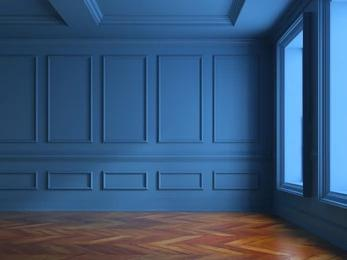

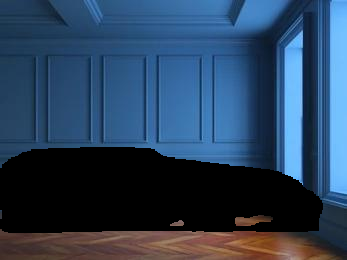

RuntimeError: ignored

In [81]:
filler.eval()
orig, masked = random_mask(974)
cv2_imshow(orig)
cv2_imshow(masked)
masked = torch.tensor(np.transpose(masked)).to(device) / 255.0
pred = filler(masked.unsqueeze(dim=0))
pred = np.transpose(pred.squeeze(dim=0).detach().cpu().numpy() * 255.0)
cv2_imshow(pred)
pred

## Linear autoencoder

In [2]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(227*227, 10000)
        self.fc2 = nn.Linear(10000, 1000)
        self.fc3 = nn.Linear(1000, 200)
        self.fc4 = nn.Linear(200, 1000)
        self.fc5 = nn.Linear(1000, 10000)
        self.fc6 = nn.Linear(10000, 227*227)

    def forward_encoder(self, x):
        x = x / 255.0
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
    
    def forward_decoder(self, x):
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x * 255
    
    def forward(self, x):
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)   
        return x

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.5
criterion = nn.MSELoss()
filler = Net().to(device)
optimizer = optim.SGD(filler.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [11]:
for epoch in range(EPOCHS):
    filler.train()
    total_loss = 0.0
    for i in tqdm(range(1328)):
        # orig, masked = random_mask(i)
        orig = Image.open('/content/EE596_Project/data/empty/'+str(i)+'.jpg').convert('LA')
        orig = orig.resize([227, 227])
        orig = np.squeeze(np.array(orig)[:, :, 0])
        orig = np.reshape(orig, (1, 227*227))
        orig = torch.tensor(orig).to(device)

        masked = Image.open('/content/EE596_Project/data/masked_empty/'+str(i)+'.jpg').convert('LA')
        masked = masked.resize([227, 227])
        masked = np.squeeze(np.array(masked)[:, :, 0])
        masked = np.reshape(masked, (1, 227*227))
        masked = torch.tensor(masked).to(device)

        optimizer.zero_grad()
        pred = filler(masked)
        loss = criterion(pred/255.0, orig/255.0) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('[Epoch: %d]\tLoss: %.6f' % (epoch, (total_loss/1328)))


[Epoch: 0]	Loss: 0.026428



[Epoch: 1]	Loss: 0.026264


KeyboardInterrupt: ignored

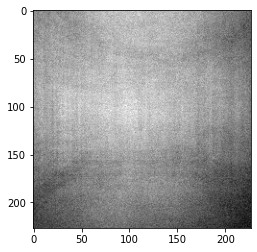

In [15]:
filler.eval()
i = 974
orig = Image.open('/content/EE596_Project/data/empty/'+str(i)+'.jpg').convert('LA')
orig = orig.resize([227, 227])
plt.imshow(orig)
orig = np.squeeze(np.array(orig)[:, :, 0])
orig = np.reshape(orig, (1, 227*227))
orig = torch.tensor(orig).to(device)

masked = Image.open('/content/masked/'+str(i)+'.jpg').convert('LA')
masked = masked.resize([227, 227])
plt.imshow(masked)
masked = np.squeeze(np.array(masked)[:, :, 0])
masked = np.reshape(masked, (1, 227*227))
masked = torch.tensor(masked).to(device)


pred = filler(masked)
pred = np.reshape(pred.detach().cpu().numpy(), (227, 227))
plt.imshow(pred, cmap='gray')